<a href="https://colab.research.google.com/github/maria-jahan20/Teeth-detection-using-VLM/blob/main/Florence_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Installation

In [1]:
!pip install -q transformers flash_attn timm einops peft
!pip install -q roboflow git+https://github.com/roboflow/supervision.git
!pip install -q transformers flash_attn timm einops peft
!pip install -q roboflow git+https://github.com/roboflow/supervision.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 36.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


##Imports

In [2]:
import io
import os
import re
import json
import torch
import html
import base64
import itertools
import numpy as np
import supervision as sv

from google.colab import userdata
from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
from roboflow import Roboflow

##Dataset Load



In [3]:
rf = Roboflow(api_key="fwZ8YmD6kXjTnpU7rfQO")
project = rf.workspace("teethsegmentation").project("final_dataset-tznt6")
version = project.version(6)
dataset = version.download("florence2-od")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to final_dataset-6 in florence2-od:: 100%|██████████| 398/398 [00:00<00:00, 1312.56it/s]


##Florence-2 Base model

In [4]:
CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION)


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

Importing from timm.models.layers is deprecated, please import via timm.layers


pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


##Dataset class

In [5]:
class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

##DataLoader for train and validation set

In [6]:
BATCH_SIZE = 4
NUM_WORKERS = 0

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

train_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/train/annotations.jsonl",
    image_directory_path = f"{dataset.location}/train/"
)
val_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/valid/annotations.jsonl",
    image_directory_path = f"{dataset.location}/valid/"
)
test_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/test/annotations.jsonl",
    image_directory_path = f"{dataset.location}/test/"
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

##LORA set up


In [7]:
config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
    revision=REVISION
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 1,929,928 || all params: 272,733,896 || trainable%: 0.7076


##Empty cache for more storage

In [8]:
torch.cuda.empty_cache()

##Inference code on validation dataset


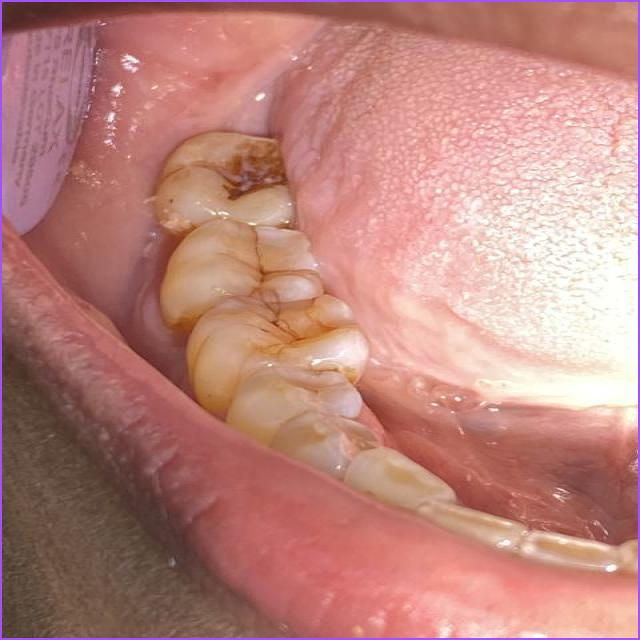
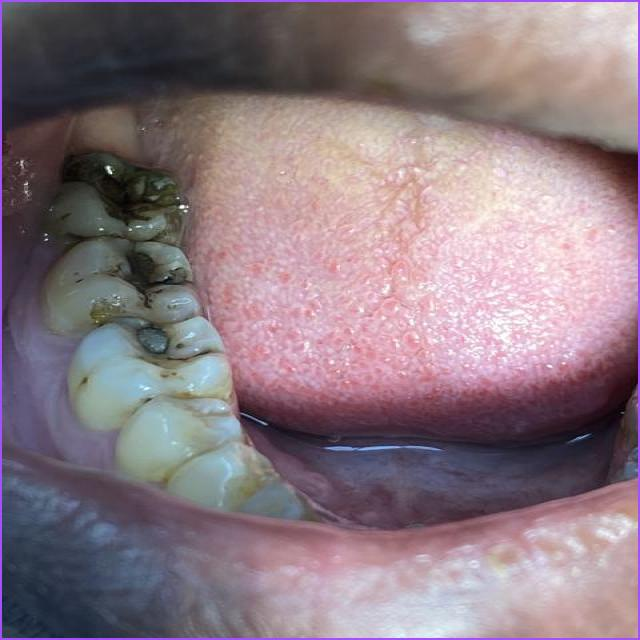
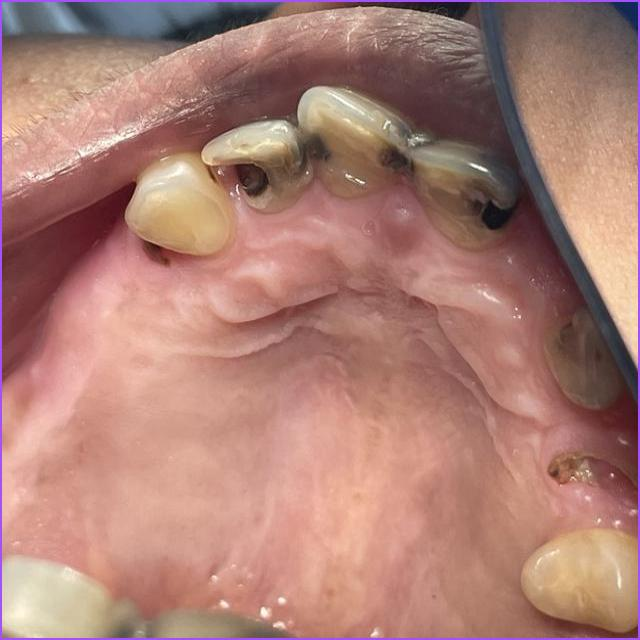
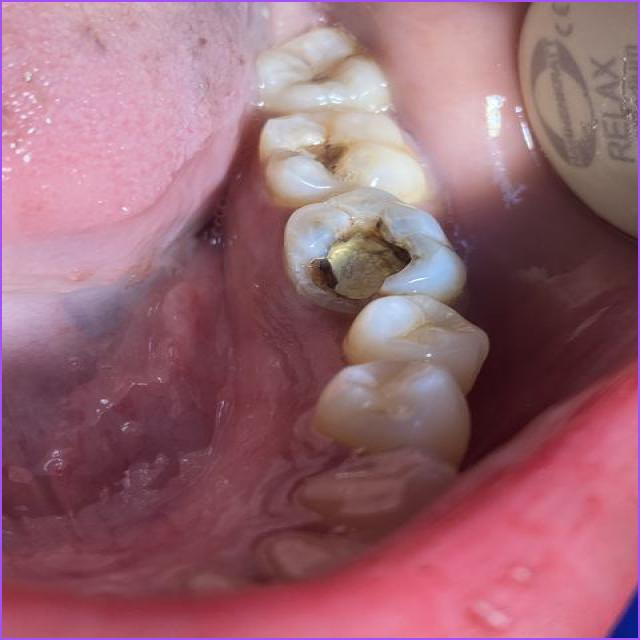

In [9]:
def render_inline(image: Image.Image, resize=(256, 256)):
    """Convert image into inline html."""
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image: Image.Image, response):
    try:
        detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
        image = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(), detections)
        image = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image, detections)
    except:
        print('failed to render model responses')
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:256px; height:256px;" src="{render_inline(image, resize=(256, 256))}" />
    <p style="width:512px; margin:10px; font-size:small;">{html.escape(json.dumps(response))}</p>
</div>
"""


def render_inference_results(model, dataset: DetectionDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        answer = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
        html_out += render_example(image, answer)

    display(HTML(html_out))

render_inference_results(peft_model, val_dataset, 4)

In [10]:
class EarlyStopping:
    def __init__(self, patience=2, min_delta=0.0):
        """
        Initialize EarlyStopping.

        Args:
            patience (int): Number of epochs to wait for improvement.
            min_delta (float): Minimum change in validation loss to be considered an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.should_stop = False

    def __call__(self, current_loss):
        """
        Check if training should stop.

        Args:
            current_loss (float): Current validation loss.
        """
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True


##Preprocessing training set before running epochs

In [11]:
def train_model(train_loader, val_loader, model, processor, epochs=20, lr=5e-6, patience=2):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

        # Early Stopping Check
        early_stopping(avg_val_loss)
        if early_stopping.should_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            break

        # Save Model
        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)


##Epochs

In [12]:
%%time

EPOCHS = 10
LR = 5e-5

train_model(train_loader, val_loader, peft_model, processor, epochs=EPOCHS, lr=LR)

Training Epoch 1/10: 100%|██████████| 86/86 [02:25<00:00,  1.70s/it]


Average Training Loss: 4.148709220941677


Validation Epoch 1/10: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]
Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.


Average Validation Loss: 3.145172664097377


Training Epoch 2/10: 100%|██████████| 86/86 [02:24<00:00,  1.68s/it]


Average Training Loss: 1.9183060637740201


Validation Epoch 2/10: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


Average Validation Loss: 3.0454677513667514


Training Epoch 3/10: 100%|██████████| 86/86 [02:24<00:00,  1.68s/it]


Average Training Loss: 1.7049526031627211


Validation Epoch 3/10: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]


Average Validation Loss: 3.0267361232212613


Training Epoch 4/10: 100%|██████████| 86/86 [02:25<00:00,  1.69s/it]


Average Training Loss: 1.594954720763273


Validation Epoch 4/10: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


Average Validation Loss: 3.0272300243377686


Training Epoch 5/10: 100%|██████████| 86/86 [02:25<00:00,  1.69s/it]


Average Training Loss: 1.5177920405254808


Validation Epoch 5/10: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]

Average Validation Loss: 3.0315563678741455
Early stopping triggered at epoch 5.
CPU times: user 11min 48s, sys: 34.3 s, total: 12min 22s
Wall time: 12min 32s


##Using Regex for extract classes

In [13]:
import re

PATTERN = r'(\d)<loc_'
suffix = "0<loc_307><loc_227><loc_448><loc_316>3<loc_248><loc_320><loc_307><loc_383>1<loc_388><loc_412><loc_429><loc_438>"
matches = re.findall(PATTERN, suffix)
print(matches)


['0', '3', '1']


In [14]:
def extract_classes(dataset: DetectionDataset):
    """
    Extract unique class labels from the dataset.
    """
    class_set = set()
    for i in range(len(dataset.dataset)):
        _, data = dataset.dataset[i]
        suffix = data["suffix"]
        classes = re.findall(PATTERN, suffix)  # Use the correct regex
        class_set.update(classes)
    return sorted(class_set)


##Extracting classes after training

In [15]:
CLASSES = extract_classes(train_dataset)
print(CLASSES)

['0', '1', '2', '3', '4']


##Prediction code

In [16]:
targets = []
predictions = []

for i in range(len(val_dataset.dataset)):
    image, data = val_dataset.dataset[i]
    prefix = data['prefix']
    suffix = data['suffix']

    # Generate predictions
    inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    # Process predictions
    prediction = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
    prediction = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, prediction, resolution_wh=image.size)
    prediction = prediction[np.isin(prediction['class_name'], CLASSES)]
    prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
    prediction.confidence = np.ones(len(prediction))  # Set dummy confidence scores

    # Process targets
    target = processor.post_process_generation(suffix, task='<OD>', image_size=image.size)
    target = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, target, resolution_wh=image.size)
    target.class_id = np.array([
        CLASSES.index(class_name) if class_name in CLASSES else -1
        for class_name in target['class_name']
    ])
    valid_indices = target.class_id != -1  # Filter invalid classes
    target = target[valid_indices]

    # Append to lists
    targets.append(target)
    predictions.append(prediction)



##Mean average precision calculation

In [21]:
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.04
map50: 0.10
map75: 0.03


In [22]:
print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred: {len(y_pred)}")


Length of y_true: 123
Length of y_pred: 123


In [26]:
# Initialize lists for true and predicted labels
y_true = []
y_pred = []

for target, prediction in zip(targets, predictions):
    # Debugging: Print lengths
    print(f"Target id name:{target.class_id}")
    print(f"Target length: {len(target.class_id)}, Prediction length: {len(prediction.class_id)}")

    # Align lengths if there's a mismatch
    min_length = min(len(target.class_id), len(prediction.class_id))
    y_true.extend(target.class_id[:min_length].tolist())
    y_pred.extend(prediction.class_id[:min_length].tolist())

# Calculate precision and recall
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

# Print results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Target id name:[0 3 1 1 1]
Target length: 5, Prediction length: 8
Target id name:[1 0 1 0 0 0]
Target length: 6, Prediction length: 4
Target id name:[2 2 0 3 0 0 0]
Target length: 7, Prediction length: 4
Target id name:[1 1 2 2]
Target length: 4, Prediction length: 4
Target id name:[2 1 1 0 0 0 0]
Target length: 7, Prediction length: 4
Target id name:[3 0 0 0 0 0 0 0]
Target length: 8, Prediction length: 1
Target id name:[0 0 0 0 0 0 0 0 0]
Target length: 9, Prediction length: 4
Target id name:[3 0 0 0 0 0 0 0 0]
Target length: 9, Prediction length: 7
Target id name:[1 1 1 3 4 0 4 4 1]
Target length: 9, Prediction length: 8
Target id name:[4 4 2]
Target length: 3, Prediction length: 1
Target id name:[1 1 1 4 1 4 0]
Target length: 7, Prediction length: 5
Target id name:[2 3 1 2]
Target length: 4, Prediction length: 3
Target id name:[4 4 4 4 4 4 0 0 0 0 0 0 2]
Target length: 13, Prediction length: 10
Target id name:[2 2 1 1 2 2 0]
Target length: 7, Prediction length: 7
Target id name:[0 

##Confusion matrix

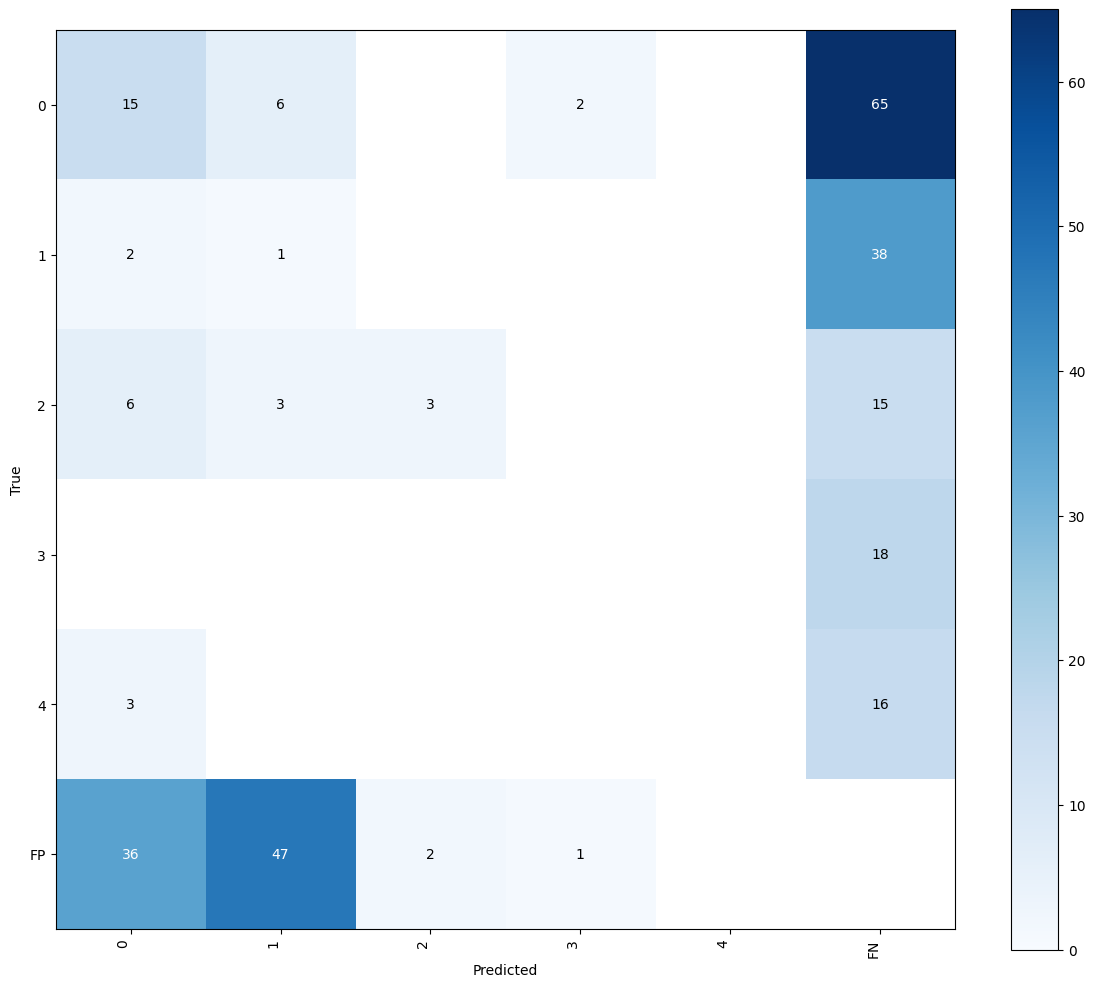

In [27]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()


##Test fune tuned model on a random image from test set

In [28]:
EXAMPLE_IMAGE_PATH = "/content/final_dataset-6/test/intraoral_lower-1-_JPEG.rf.e5896401bd771f8b42d3b4d25bd0ea38.jpg"

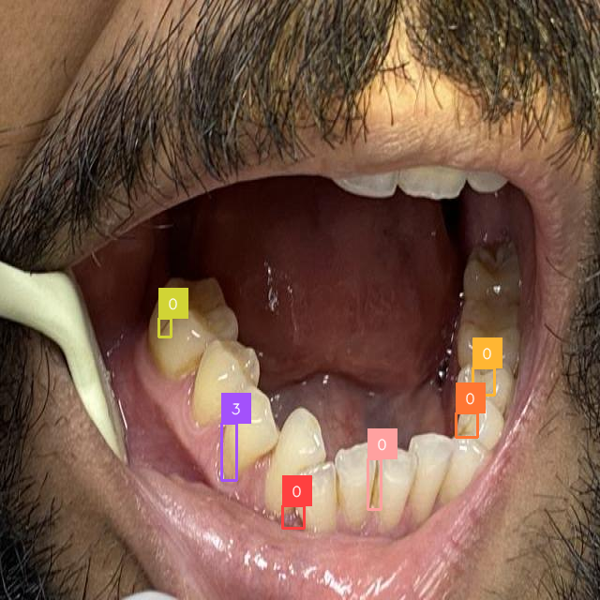

In [29]:
image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<OD>"
text = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = peft_model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image